In [12]:
import numpy as np
import pandas as pd

from src.data_preprocessing import clean_text, transform_tfidf
from src.model import gradient_descent, predict, pred_to_accuracy
from src.viz import graph_log_loss

In [2]:
# Read data
train_raw = pd.read_csv("data/train.csv")
test_raw = pd.read_csv("data/test.csv")
y_test_raw = pd.read_csv("data/submit.csv")

In [3]:
# Implement data cleaning and text preprocessing
test_raw = test_raw.join(y_test_raw["label"])
train_clean = clean_text(train_raw)
test_clean = clean_text(test_raw)
y_train = train_clean["label"].to_numpy()
y_test = test_clean["label"].to_numpy()

/Users/nuriaadellraventos/Library/CloudStorage/OneDrive-TheUniversityofChicago/Classes/MathML/proj/mathml_finalproj/src/data_preprocessing.py:28: FutureWarning: The default value of regex will change from True to False in a future version.
  col = col.str.replace('[^\w\s]', '')\


In [4]:
# tf-idf transformation
X_train, X_test, words = transform_tfidf(train_clean["text"], test_clean["text"])

X_train = X_train.todense()
X_test = X_test.todense()
X_train.shape

(18285, 16770)

In [5]:
n, p = X_train.shape

# Shuffle training data
indices = np.random.permutation(n)
X_train = X_train[indices,:]
y_train = y_train[indices]

# Set training parameters
folds = 3
n_alphas = 10
lambdas = [0.01, 0.001, 0.0001, 0.00001, 0.000001, 0.0000001, 0.00000001, 0.000000001]

In [6]:
# Get average train log loss for each lambda and alpha
avg_loss_by_penalty = np.empty((n_alphas + 1,len(lambdas)))
for i, lambda_ in enumerate(lambdas):
    log_loss = np.empty((n_alphas+ 1,folds))
    buckets = list(range(0, n + 1, n//folds))
    
    for k in range(folds):
        val1 = buckets[k]
        val2 = buckets[k+1]

        X_val_bucket = X_train[val1:val2,:]
        X_train_buckets = np.delete(X_train, np.s_[val1:val2], axis=0)

        y_val = y_train[val1:val2]
        y_train2 = np.delete(y_train, np.s_[val1:val2], axis=0)

        log_loss[:,k] = gradient_descent(X_train_buckets, X_val_bucket, y_train2, y_val, n_alphas, lambda_)

    avg_loss_by_penalty[:,i] = np.mean(log_loss, axis=1)

In [7]:
print(avg_loss_by_penalty)

[[0.69513554 0.1643716  0.02963964 0.02401345 0.02421694 0.02391261
  0.02349704]
 [0.69314534 0.22711106 0.02973999 0.02374878 0.02362874 0.02331058
  0.022768  ]
 [0.69317779 0.29512253 0.03129266 0.0239659  0.02383939 0.0239227
  0.02369834]
 [0.69319568 0.36968292 0.03216016 0.02414906 0.02378911 0.02398798
  0.02399543]
 [0.69321307 0.45554096 0.03292486 0.0242302  0.02320237 0.0233699
  0.02411636]
 [0.69326137 0.5250528  0.03295758 0.0245833  0.02386181 0.02333218
  0.02341481]
 [0.6932793  0.58366831 0.03510057 0.02487669 0.0243181  0.02297626
  0.02351773]
 [0.69327659 0.6334699  0.03573573 0.02464527 0.02343267 0.02268904
  0.02331501]
 [0.69328235 0.66911913 0.03667442 0.02514452 0.0234042  0.02349951
  0.02358722]
 [0.69326945 0.68809843 0.03677022 0.02481655 0.02406202 0.02386992
  0.02379214]
 [0.69319948 0.69315818 0.03811864 0.0246116  0.02435605 0.02344422
  0.02321778]]


In [8]:
def get_best_vals(avg_err_array, lambdas):
    ind_ridge = (np.where(avg_err_array[0] == avg_err_array[0].min())[0][0])
    ind_lasso = (np.where(avg_err_array[10] == avg_err_array[10].min())[0][0])

    enl_matrix = avg_err_array[1:10]
    alpha_idx, en_lambda_idx = np.where(enl_matrix == np.min(enl_matrix))
    alpha_idx += 1

    ridge_lambda = lambdas[ind_ridge]
    lasso_lambda = lambdas[ind_lasso]
    en_lambda = lambdas[en_lambda_idx[0]]
    best_alpha = alpha_idx[0] * 0.1

    return  ridge_lambda, lasso_lambda, en_lambda, best_alpha

<AxesSubplot:title={'center':'Average Error by Model Specification'}, xlabel='lambda', ylabel='Average Error Rate'>

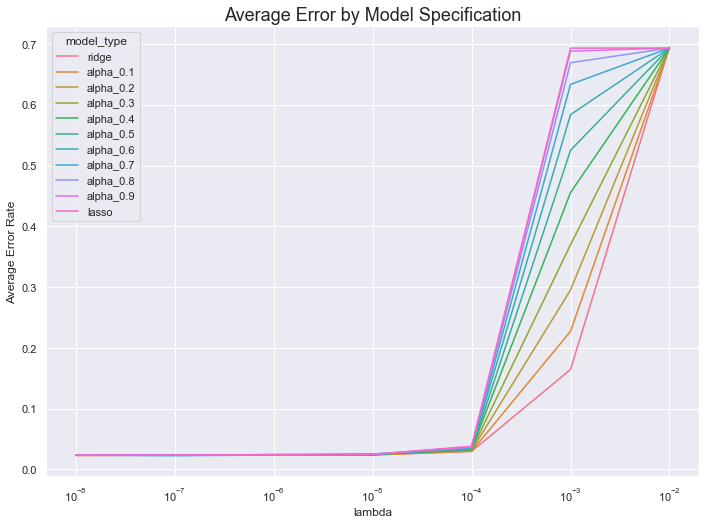

In [9]:
graph_log_loss(avg_loss_by_penalty)

In [10]:
ridge_lambda, lasso_lambda, en_lambda, best_alpha = get_best_vals(avg_loss_by_penalty, lambdas)
print("Best lambda for ridge regularization: ", ridge_lambda)
print("Best lambda for lasso regularization: ", lasso_lambda)
print("Best lambda for elastic net regularization: ", en_lambda)
print("Best alpha for elastic net regularization: ", best_alpha)

Best lambda for ridge regularization:  1e-06
Best lambda for lasso regularization:  1e-06
Best lambda for elastic net regularization:  1e-05
Best alpha for elastic net regularization:  0.7000000000000001


In [44]:
# Train data predictions
train_pred_ridge = predict(X_train, y_train,  X_train, 0, ridge_lambda, 0.01, 100000)
train_pred_lasso = predict(X_train, y_train,  X_train, 1, lasso_lambda, 0.01, 100000)
train_pred_en = predict(X_train, y_train,  X_train, best_alpha, en_lambda, 0.01, 100000)

In [43]:
threshold = 0.5
train_pred_en = predict(X_train, y_train,  X_train, best_alpha, en_lambda, 0.01, 100000)
train_accuracy_en = pred_to_accuracy(train_pred_en, y_train, threshold)
train_accuracy_en

KeyboardInterrupt: 

In [39]:
train_accuracy_en

0.8257588187038556

In [45]:
# Select threshold and calculate train accuracy
threshold = 0.5
train_accuracy_r = pred_to_accuracy(train_pred_ridge, y_train, threshold)
train_accuracy_l = pred_to_accuracy(train_pred_lasso, y_train, threshold)
train_accuracy_en = pred_to_accuracy(train_pred_en, y_train, threshold)
print(train_accuracy_r)
print(train_accuracy_l)
print(train_accuracy_en)

0.8251572327044026
0.825485370522286
0.8212195788898004


In [50]:
# Test data predictions
pred_ridge = predict(X_train, y_train,  X_test, 0, ridge_lambda, 0.2, 100000)
pred_lasso = predict(X_train, y_train,  X_test, 1, lasso_lambda, 0.2, 100000)
pred_en = predict(X_train, y_train,  X_test, best_alpha, en_lambda, 0.2, 100000)

In [ ]:
# Calculate test accuracy
accuracy_r = pred_to_accuracy(pred_ridge, y_test, threshold)
accuracy_l = pred_to_accuracy(pred_lasso, y_test, threshold)
accuracy_en = pred_to_accuracy(pred_en, y_test, threshold)
print(accuracy_r)
print(accuracy_l)
print(accuracy_en)

0.5877595628415301
0.5892896174863388
0.5875409836065574
